In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as impg
from collections import deque
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
# Define a class to receive the characteristics of each line detection

class Line():
    def __init__(self, n):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen = n)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #distance between the lane and left of image
        self.lane_x_zero = None

In [3]:
def calibrate_camera(images, nx = 9, ny = 6):
    '''
    Find require parameters to calibrate camera with chessboard images
    param: 
        images: recommending at least 20 images
        nx: number of corners each row
        ny: number of corners each column
    return:
        mtx: camera matrix
        dist: distortion coeficients
    '''
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    objpoints = []
    imgpoints = []
    for img_path in camera_cal_img_paths:
        img = plt.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            #plt.imshow(img)
            objpoints.append(objp)
            imgpoints.append(corners)
            
    # camera calibration
    ret, mtx, dist, rvess, tvess = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (mtx, dist)


def threshold_sx_s(image, thres_scheme = 1, s_thres = [120, 255], r_thres = [180,255], g_thres = [200,255],
                  l_thres_shadow = [0, 155], l_thres = [155, 255], sx_thres = [20, 100]):
    '''
    Saturation and gradient of lightness on x direction thresholding the image and generate a binary image
    param:
        image: a image, require color space is RGB
        sx_thres: a list, [lower_bound, higher_bound] threshold for scaled sobel x
        s_thres: a list, [lower_bound, higher_bound] threshold for saturation channel
    return:
        a binary image after applying both thresholding 
    '''
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    r_channel = image[:, :, 0]
    g_channel = image[:, :, 1]
    
    if thres_scheme == 0:
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
        sxbinary = np.zeros_like(l_channel)
        sxbinary[(scaled_sobel >= sx_thres[0]) & (scaled_sobel < sx_thres[1])] = 1
        
        region_interest = np.ones_like(l_channel)
        region_interest[480:, 500:700] = 0
        
        combined = np.zeros_like(l_channel)
        combined[(sxbinary == 1) & region_interest == 1] = 1
        return combined

    else:
        r_binary = np.zeros_like(l_channel)
        r_binary[(r_channel >= r_thres[0]) & (r_channel < r_thres[1])] = 1

        g_binary = np.zeros_like(l_channel)
        g_binary[(g_channel >= g_thres[0]) & (g_channel < g_thres[1])] = 1

        s_binary = np.zeros_like(l_channel)
        s_binary[(s_channel >= s_thres[0]) & (s_channel < s_thres[1])] = 1
    
        l_binary_shadow = np.zeros_like(l_channel)
        l_binary_shadow[(l_channel >= l_thres_shadow[0]) & (l_channel < l_thres_shadow[1])] = 1

        l_binary = np.zeros_like(l_channel)
        l_binary[(l_channel >= l_thres[0]) & (l_channel < l_thres[1])] = 1


        combined_binary = np.zeros_like(l_channel)
        combined_binary[( ( (s_binary == 1) & (l_binary == 1) ) |
                      ( (r_binary == 1) & (l_binary_shadow == 1) ) |
                      (g_binary == 1) )] = 1
        return combined_binary


def perspective_transform(src, dest):
    '''
    Find both transform matrix and inverse transform matrix with provided srt and dest
    '''
    M = cv2.getPerspectiveTransform(src, dest)
    M_inv = cv2.getPerspectiveTransform(dest, src)
    return (M, M_inv)

In [4]:
def blind_search(side, binary_warped, undist, nwindows = 9, margin = 100, minpix = 50):
    '''
        blind search for active pixel for the specified lane, if cannot find enough pixel, try another
        thresholding scheme which will only use sobel on x direction
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    if side == 'left':
        left_lane.current_fit = None
        x_base = np.argmax(histogram[:midpoint])
    else:
        right_lane.current_fit = None
        x_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    x_current = x_base
    
    # Create empty lists to receive left and right lane pixel indices
    lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin
 
        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]

        
        # Append these indices to the lists
        lane_inds.append(good_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_inds) > minpix:
            x_current = np.int(np.mean(nonzerox[good_inds]))

    # Concatenate the arrays of indices
    lane_inds = np.concatenate(lane_inds)
    
    # Extract left and right line pixel positions
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds] 

    # Fit a second order polynomial to each
    if len(x) > 50:
        fit = np.polyfit(y, x, 2)
    
        if side == 'left':
            left_lane.allx = x
            left_lane.ally = y
            left_lane.current_fit = fit
        else:
            right_lane.allx = x
            right_lane.ally = y
            right_lane.current_fit = fit
    else:
        warped = threshold_sx_s(undist, 0)
        findLanes(warped, undist)
    

In [5]:
def margin_search(side, binary_warped, undist, nwindows = 9, margin = 100, minpix = 50):
    '''
        searching for pixels around the averaged fitted line within certain margin
        Params:
            side:          str, indicates 'left' or 'right'
            binary_warped: np.array, binary value of target image
            undist:        np.array, target image
            nwindows:      int, number of windows vertically need to search
            margin:        int, margin of best fit line set to find active pixel
            minpix:        int, minimun number of existing pixel need to update the current centeriod
    '''
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
 
    if side == 'left':
        fit = left_lane.best_fit
    else:
        fit = right_lane.best_fit
        
    lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + 
    fit[2] - margin)) & (nonzerox < (fit[0]*(nonzeroy**2) + 
    fit[1]*nonzeroy + fit[2] + margin))) 

    # Again, extract left and right line pixel positions
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds] 

    # Fit a second order polynomial to each
    if len(x) > 50:
        fit = np.polyfit(y, x, 2)
        if side == 'left':
            left_lane.allx = x
            left_lane.ally = y
            left_lane.current_fit = fit
        else:
            right_lane.allx = x
            right_lane.ally = y
            right_lane.current_fit = fit
    else:
        blind_search(side, binary_warped, undist, nwindows, margin, minpix)

In [6]:
def findLanes(binary_warped, undist, nwindows = 9, margin = 100, minpix = 50):
    '''
        Find lanes with margin search if lane was detected in previous frame, otherwise use blind search,
        If lanes found don't seem to parallel and margin search was used, try blind search instead.  
        don't quiet parallel with each other use last n averaged fitted lane.
        Params:
            binary_warped: np.array, binary value of target image
            undist:        np.array, target image
            nwindows:      int, number of windows vertically need to search
            margin:        int, margin of best fit line set to find active pixel
            minpix:        int, minimun number of existing pixel need to update the current centeriod
    '''
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    which_test_left = 'blind'
    which_test_right = 'blind'
    
    if left_lane.detected:
        margin_search('left', binary_warped, undist, nwindows, margin, minpix)
        which_test_left = 'margin'
    else:
        blind_search('left', binary_warped, undist, nwindows, margin, minpix)
    
    if right_lane.detected:
        margin_search('right', binary_warped, undist, nwindows, margin, minpix)
        which_test_right = 'margin'
    else:
        blind_search('right', binary_warped, undist, nwindows, margin, minpix)
    
        
    if which_test_left != 'blind' or which_test_right != 'blind':
        coef_diff = left_lane.current_fit[:-1] - right_lane.current_fit[:-1]
        left_coef_norm = np.linalg.norm(left_lane.current_fit[:-1], 2)
        right_coef_norm = np.linalg.norm(right_lane.current_fit[:-1], 2)
        diff_norm = np.linalg.norm(coef_diff,2) / (left_coef_norm + right_coef_norm)
        coefs_diff_norm.append(diff_norm)
        if diff_norm > 0.1:
            if which_test_left != 'blind':
                blind_search('left', binary_warped, undist, nwindows, margin, minpix)
            if which_test_right != 'blind':
                blind_search('right', binary_warped, undist, nwindows, margin, minpix)
     
    
    coef_diff = left_lane.current_fit[:-1] - right_lane.current_fit[:-1]
    left_coef_norm = np.linalg.norm(left_lane.current_fit[:-1], 2)
    right_coef_norm = np.linalg.norm(right_lane.current_fit[:-1], 2)
    diff_norm = np.linalg.norm(coef_diff,2) / (left_coef_norm + right_coef_norm)
    coefs_diff_norm_blind.append(diff_norm)   
    
    
    if diff_norm < ACCEPTED_THRES:
        left_lane.recent_xfitted.append( left_lane.current_fit[0]*ploty**2 +
                                        left_lane.current_fit[1]*ploty +
                                        left_lane.current_fit[2] )
        left_lane.bestx = np.mean(np.array(list(left_lane.recent_xfitted)), axis = 0)
        left_lane.best_fit = np.polyfit(ploty, left_lane.bestx, 2)
        left_lane.detected = True
        right_lane.recent_xfitted.append( right_lane.current_fit[0]*ploty**2 +
                                         right_lane.current_fit[1]*ploty +
                                         right_lane.current_fit[2] )
        right_lane.bestx = np.mean(np.array(list(right_lane.recent_xfitted)), axis = 0)
        right_lane.best_fit = np.polyfit(ploty, right_lane.bestx, 2)
        right_lane.detected = True
        
    elif diff_norm > SMOOTH_THRES and left_lane.best_fit is not None and right_lane.best_fit is not None:
        left_lane.current_fit = left_lane.best_fit
        left_lane.allx = left_lane.bestx
        left_lane.ally = ploty
        left_lane.detected = False
        right_lane.current_fit = right_lane.best_fit
        right_lane.allx = right_lane.bestx
        right_lane.ally = ploty
        right_lane.detected = False
        
    coef_diff = left_lane.current_fit[:-1] - right_lane.current_fit[:-1]
    left_coef_norm = np.linalg.norm(left_lane.current_fit[:-1], 2)
    right_coef_norm = np.linalg.norm(right_lane.current_fit[:-1], 2)
    diff_norm = np.linalg.norm(coef_diff,2) / (left_coef_norm + right_coef_norm)
    coefs_diff_norm_smooth.append(diff_norm)  

In [7]:
def projectLane(image, M_inv):
    
    left_fit = left_lane.current_fit
    right_fit = right_lane.current_fit
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

In [8]:
def cal_curvature(side, y_eval, h = 20, ym_per_pix = 30/720, xm_per_pix = 3.7/800):
    
    if side == 'left':
        x, y = left_lane.allx, left_lane.ally
    else:
        x, y = right_lane.allx, right_lane.ally
        
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    # Now our radius of curvature is in meters
    lane_x_zero = fit_cr[0] * h**2 + fit_cr[1] * h + fit_cr[2]
    
    if side == 'left':
        left_lane.lane_x_zero = lane_x_zero
        left_lane.radius_of_curvature = curverad
    else:
        right_lane.lane_x_zero = lane_x_zero
        right_lane.radius_of_curvature = curverad
        

In [9]:
def add_desc(new_image, num_pix_x, xm_per_pix = 3.7/800):
    
    lane_center = (right_lane.lane_x_zero - left_lane.lane_x_zero)
    vehicle_center = (num_pix_x * xm_per_pix) / 2
    
    to_left = lane_center - vehicle_center
    text1 = 'Radius of curvature: {0:.0f}(m)'.format(
    (left_lane.radius_of_curvature + right_lane.radius_of_curvature) / 2)
    
    side_text = 'left' if to_left > 0 else 'right'
    
    text2 = 'Vehicle is {:.3f} m {} to the center'.format(abs(to_left), side_text)
    result = new_image.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, text1, (100,100), font, 1, (255,255,255),2, cv2.LINE_AA)
    cv2.putText(result, text2, (100,150), font, 1,(255,255,255), 2, cv2.LINE_AA)
    
    return result

In [10]:
def process_image(image):
    images.append(image)
    undist = cv2.undistort(image,
                           mtx,
                           dst,
                           None, 
                           mtx)
    binary_warped = threshold_sx_s(undist)
    warped = cv2.warpPerspective(binary_warped, 
                                 M, 
                                 binary_warped.shape[::-1], 
                                 flags = cv2.INTER_LINEAR)
    
    findLanes(warped, undist)

    new_image= projectLane(undist, 
                           M_inv)
    
    cal_curvature('left', new_image.shape[0])
    cal_curvature('right', new_image.shape[0])
    
    new_image = add_desc(new_image, new_image.shape[1])
    
    return new_image

In [11]:
camera_cal_img_paths = list(map(lambda path: './camera_cal/' + path.split('\\')[-1] ,
                     glob.glob('./camera_cal/*.jpg')))
camera_cal_imgs = [plt.imread(img_path) for img_path in camera_cal_img_paths]


In [12]:
test_img_paths = list(map(lambda path: './test_images/' + path.split('\\')[-1],
                          glob.glob('./test_images/*.jpg')))
test_imgs = [plt.imread(img_path) for img_path in test_img_paths]

In [13]:
mtx, dst = calibrate_camera(camera_cal_imgs, 9, 6)

### Project Video

In [14]:
src = np.float32([[570, 467],
                  [206, 720], 
                  [715, 467],
                  [1100, 720]])
dest = np.float32([[325, 200],
                   [325, 720],
                   [968, 200],
                   [968, 720]])

M, M_inv = perspective_transform(src, dest)

In [15]:
clip = VideoFileClip("./project_video.mp4")

In [19]:
keep_last_n_frame = 10
ACCEPTED_THRES= 0.5
SMOOTH_THRES = 0.7
left_lane = Line(keep_last_n_frame)
right_lane = Line(keep_last_n_frame)
coefs_diff_norm = []
coefs_diff_norm_blind = []
coefs_diff_norm_smooth = []
images = []
out_clip = clip.fl_image(process_image)

In [20]:
output = './out_clip.mp4'
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./out_clip.mp4
[MoviePy] Writing video ./out_clip.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:38<00:00, 12.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./out_clip.mp4 

Wall time: 1min 39s


0.9999998395574723
627
1006


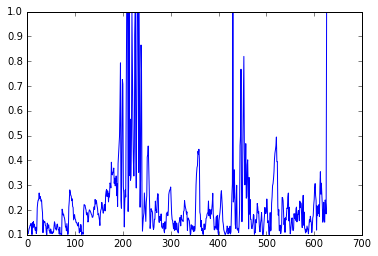

In [21]:
coefs_diff_norm = np.array(coefs_diff_norm)
print(np.max(coefs_diff_norm))
print(np.sum(coefs_diff_norm > 0.1))
print(len(coefs_diff_norm))
plt.plot(range(len(coefs_diff_norm[coefs_diff_norm > 0.1])), coefs_diff_norm[coefs_diff_norm > 0.1])

0.9999999999999882
262


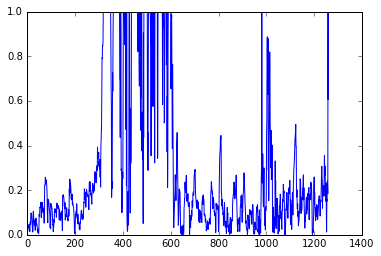

In [22]:
coefs_diff_norm_blind = np.array(coefs_diff_norm_blind)
print(np.max(coefs_diff_norm_blind))
print(np.sum(coefs_diff_norm_blind > 0.5))
plt.plot(range(len(coefs_diff_norm_blind)), coefs_diff_norm_blind)

0.999999666716637
117


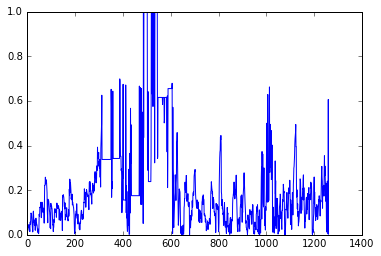

In [23]:
coefs_diff_norm_smooth = np.array(coefs_diff_norm_smooth)
print(np.max(coefs_diff_norm_smooth))
print(np.sum(coefs_diff_norm_smooth > 0.5))
plt.plot(range(len(coefs_diff_norm_smooth)), coefs_diff_norm_smooth)

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Challenge Video

In [34]:
src = np.float32([[570, 467],
                  [206, 720], 
                  [715, 467],
                  [1100, 720]])
dest = np.float32([[325, 200],
                   [325, 720],
                   [968, 200],
                   [968, 720]])

M, M_inv = perspective_transform(src, dest)

In [35]:
challenge_clip = VideoFileClip("./challenge_video.mp4")

In [36]:
keep_last_n_frame = 25
ACCEPTED_THRES= 0.5
SMOOTH_THRES = 0.5
left_lane = Line(keep_last_n_frame)
right_lane = Line(keep_last_n_frame)
coefs_diff_norm = []
coefs_diff_norm_blind = []
coefs_diff_norm_smooth = []
images = []
out_clip = challenge_clip.fl_image(process_image)

In [37]:
output = './challenge_out_clip.mp4'
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./challenge_out_clip.mp4
[MoviePy] Writing video ./challenge_out_clip.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:35<00:00, 14.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_out_clip.mp4 

Wall time: 36.4 s


0.999999998605355
238
316


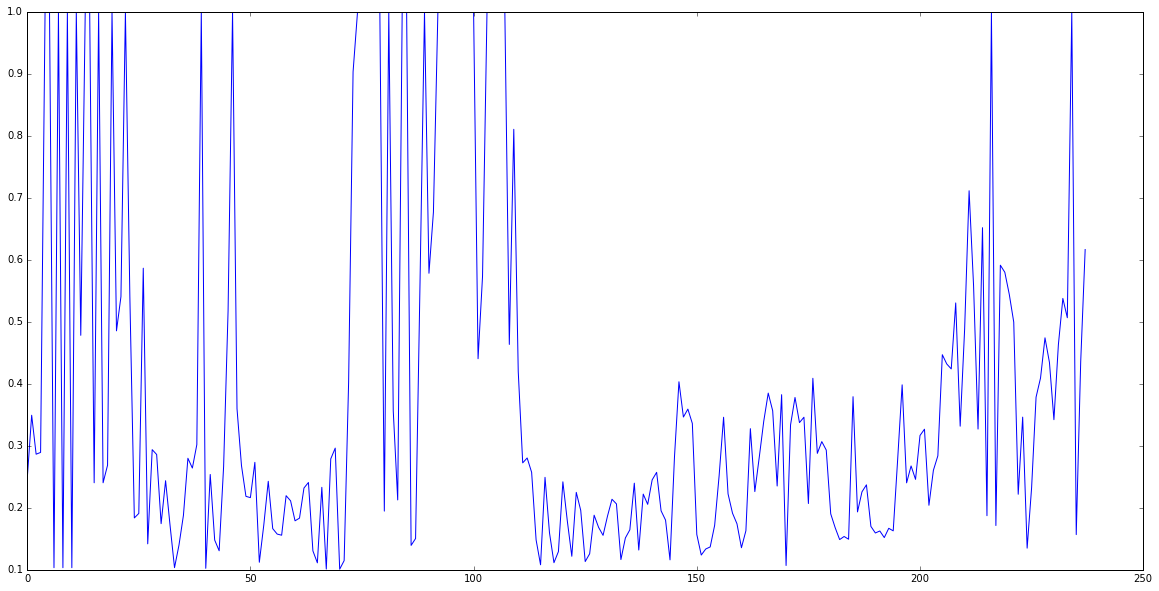

In [38]:
coefs_diff_norm = np.array(coefs_diff_norm)
print(np.max(coefs_diff_norm))
print(np.sum(coefs_diff_norm > 0.1))
print(len(coefs_diff_norm))
plt.plot(range(len(coefs_diff_norm[coefs_diff_norm > 0.1])), coefs_diff_norm[coefs_diff_norm > 0.1])

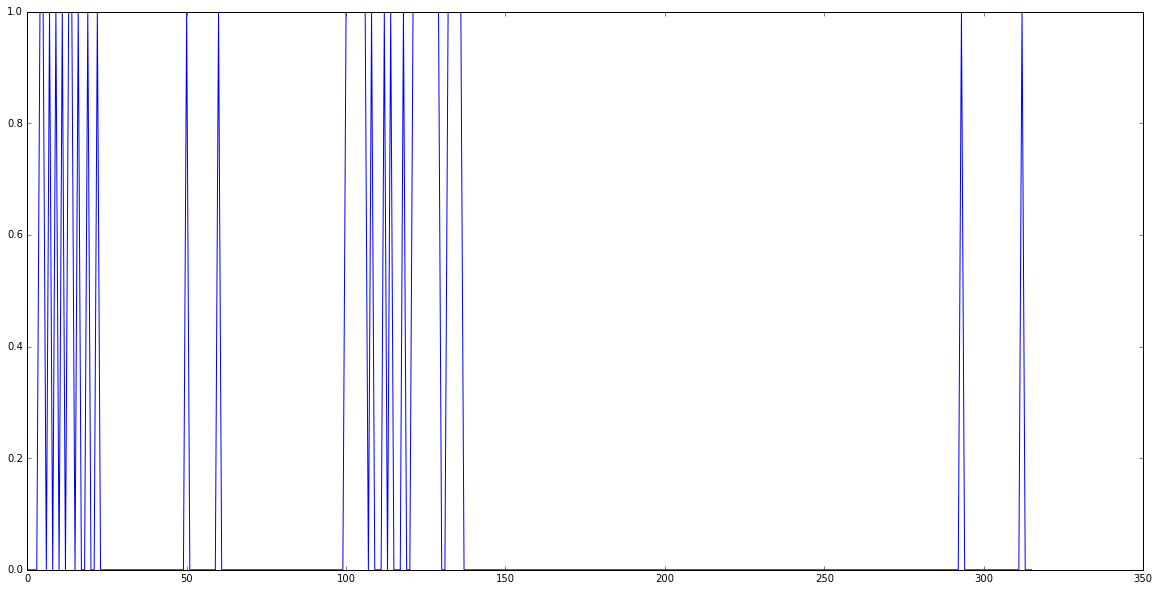

In [39]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(range(len(coefs_diff_norm)), coefs_diff_norm > 0.9)

0.999999999975219
216


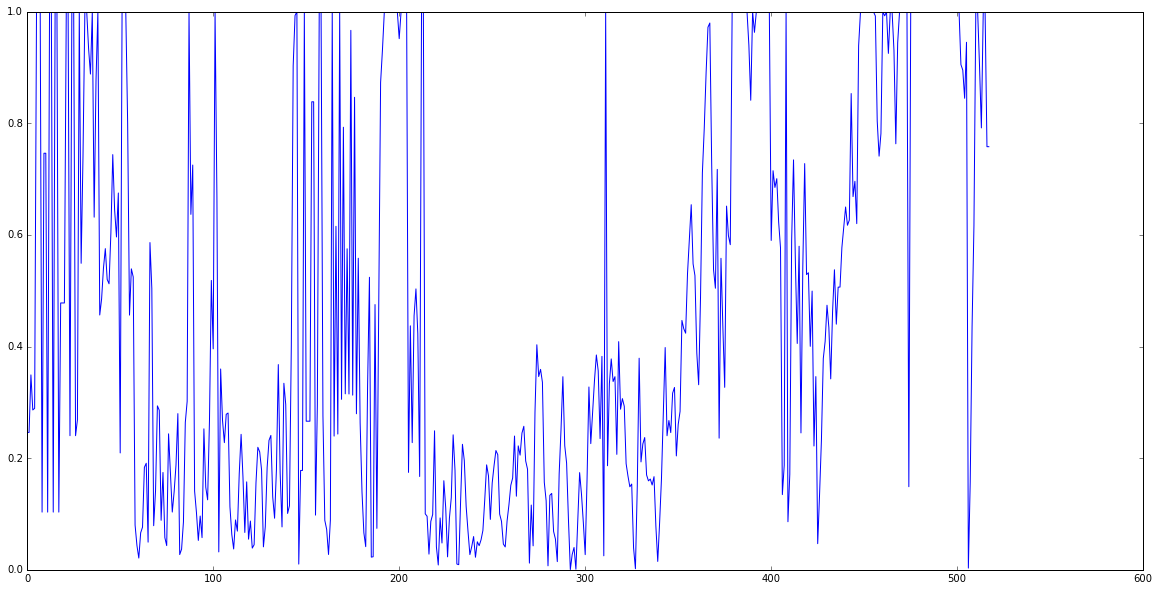

In [40]:
coefs_diff_norm_blind = np.array(coefs_diff_norm_blind)
print(np.max(coefs_diff_norm_blind))
print(np.sum(coefs_diff_norm_blind > 0.5))
plt.plot(range(len(coefs_diff_norm_blind)), coefs_diff_norm_blind)

0.49948969912551405
0


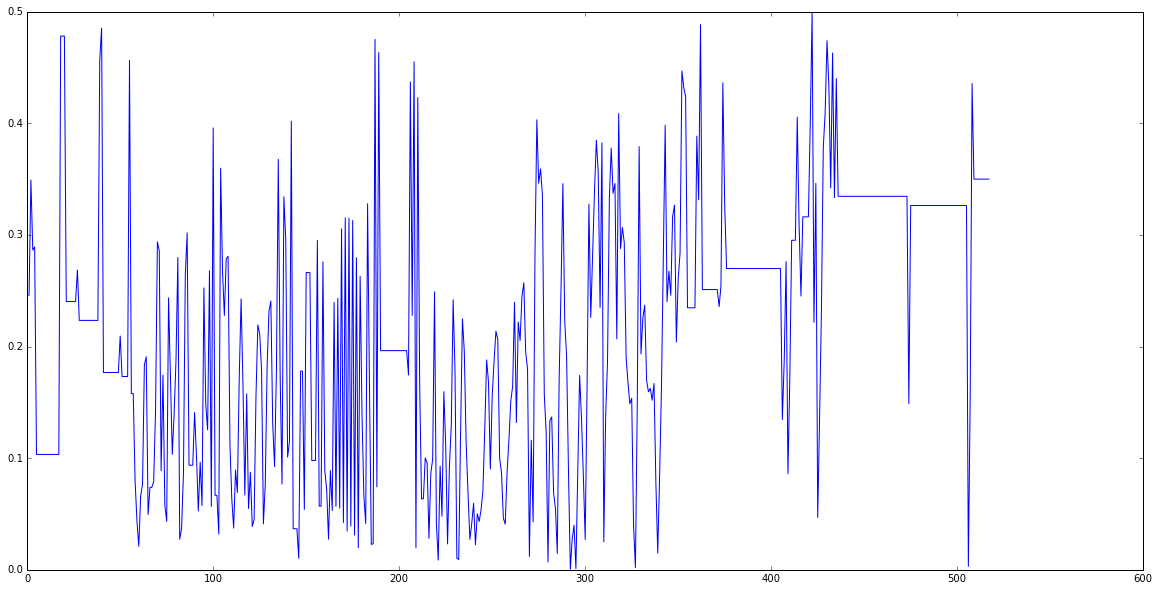

In [41]:
coefs_diff_norm_smooth = np.array(coefs_diff_norm_smooth)
print(np.max(coefs_diff_norm_smooth))
print(np.sum(coefs_diff_norm_smooth > 0.5))
plt.plot(range(len(coefs_diff_norm_smooth)), coefs_diff_norm_smooth)

In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))